# <center> CNN-RNN Computer Vision Model fusion with Knowledge Based AI</center>

## 0. Importing Libraries

In [1]:
!python --version

import warnings
warnings.filterwarnings('ignore')

Python 3.11.5


In [1]:
import numpy as np 
import pandas as pd

import os
import math
import matplotlib.pyplot as plt

import keras
from keras.utils import np_utils
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.resnet import ResNet50
from keras.layers import Input, Dense, GlobalAveragePooling2D, Dense, LSTM, Dropout
# from keras.layers.embeddings import Embedding
from keras.utils import pad_sequences
from keras.preprocessing import sequence
from tensorflow.keras.optimizers import SGD, Adam
from keras import backend as K
import tensorflow as tf

from sklearn.model_selection import train_test_split  
from functools import partial

%matplotlib inline
np.random.seed(7)

In [3]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

## 1. Loading Training Data

In [4]:
images = np.load('images.npy', allow_pickle=True)
print(images.shape)
print(images[0].shape)

(5647,)
(32, 224, 224, 3)


In [5]:
labels = np.load('one_hot_labels.npy', allow_pickle=True)
print(labels.shape)

indexes = np.load('sample_indexes.npy', allow_pickle=True)
print(indexes.shape)

(5647, 6)
(1129,)


In [6]:
plays = np.load('plays.npy', allow_pickle=True)
print(plays.shape)

(5647,)


In [7]:
# Code to obtain the indexes of plays from the 2017 season (very low quality) as part of our optimizations
##We would have to do something similar to exclude the plays we have classified as bad for whatever reason: started too early, late, full screen graphic, etc.

plays_df = pd.DataFrame(data=plays).apply(lambda x: x.str[:4])
idx_2017 = plays_df[plays_df[0].isin(['6016','6017'])].index

# Removing those plays form the labels array

labels_df = pd.DataFrame(data=labels)
labels_df[4][labels_df[5] == 1.0] = 1.0
del labels_df[5]
labels = labels_df.to_numpy()
labels = labels[[i for i in range(len(plays)) if i not in idx_2017]]
labels.shape

(5445, 5)

### 3.1 ResNet50

In [8]:
resnet_cnn_images = np.load('./resnet_cnn_images.npy', allow_pickle=True)
print(resnet_cnn_images.shape)
print(resnet_cnn_images[0].shape)

(5647,)
(32, 2048)


In [9]:
# Removing 2017 low quality plays form the image feature vectors array

cnn_images = resnet_cnn_images[[i for i in range(len(plays)) if i not in idx_2017]]
cnn_images.shape

(5445,)

In [10]:
##VGG16 model
cnn_images = resnet_cnn_images[[i for i in range(len(plays)) if i not in idx_2017]]
cnn_images.shape

(5445,)

# 4. Building the LSTM Network

In [11]:

train_idx = np.random.choice(len(cnn_images), size=int(len(cnn_images) * 0.8), replace=False)
test_idx = list(set(train_idx) ^ set([x for x in range(len(cnn_images))]))

In [12]:
X_train = resnet_cnn_images[train_idx]
X_test = resnet_cnn_images[test_idx]

y_train = labels[train_idx]
y_test = labels[test_idx]

In [13]:
X_train_pad = pad_sequences(X_train, maxlen=30)
X_test_pad = pad_sequences(X_test, maxlen=30)

In [14]:
X_train_pad.shape
y_train.shape
X_train.shape
resnet_cnn_images[0].shape
print(train_idx)
print(len(cnn_images))

[2366 4448 2185 ... 1672 1199 2229]
5445


In [15]:
# Second LSTM Architecture
model = Sequential()
model.add(LSTM(64, return_sequences=True,input_shape=(30, 2048)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64)) 
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=8, batch_size=32)
print(model.summary())


Epoch 1/8
137/137 [==============================] - 40s 247ms/step - loss: 0.8133 - accuracy: 0.6752 - val_loss: 0.6496 - val_accuracy: 0.7530
Epoch 2/8
137/137 [==============================] - 34s 247ms/step - loss: 0.5936 - accuracy: 0.7782 - val_loss: 0.5869 - val_accuracy: 0.7860
Epoch 3/8
137/137 [==============================] - 33s 241ms/step - loss: 0.5496 - accuracy: 0.7966 - val_loss: 0.5888 - val_accuracy: 0.7870
Epoch 4/8
137/137 [==============================] - 31s 229ms/step - loss: 0.4824 - accuracy: 0.8271 - val_loss: 0.5604 - val_accuracy: 0.7998
Epoch 5/8
137/137 [==============================] - 32s 234ms/step - loss: 0.4227 - accuracy: 0.8540 - val_loss: 0.5705 - val_accuracy: 0.8044
Epoch 6/8
137/137 [==============================] - 32s 235ms/step - loss: 0.3887 - accuracy: 0.8655 - val_loss: 0.5547 - val_accuracy: 0.8053
Epoch 7/8
137/137 [==============================] - 33s 241ms/step - loss: 0.3291 - accuracy: 0.8873 - val_loss: 0.5829 - val_accuracy:

In [16]:
# from sklearn.model_selection import GridSearchCV
# from scikeras.wrappers import KerasClassifier

# #100 should be a good batch size for larger datasets
# param_grid = {'epoch':[2, 4, 8, 12, 20],'batch_size':[10, 25, 32, 50, 100]}
# keras_clf = KerasClassifier(model = model, optimizer="adam")
# grid = GridSearchCV(keras_clf, param_grid, scoring = 'accuracy')
# grid.fit(X_train_pad, y_train)
# print(grid.best_params_)

## Case Based Reasoning

In [17]:
from sklearn.neighbors import NearestNeighbors

In [3]:
videos_csv = pd.read_csv('Video.csv',sep=';')
plays_csv = pd.read_csv('Play.csv',sep=';')
training_labels = pd.merge(plays_csv.iloc[:,[0,1,2,3,4,5,9,10]], videos_csv[['VideoFileName','VideoPath','PlayID','GameID']],left_on='ID', right_on='PlayID')
training_labels = training_labels[training_labels.Type.isin(['K', 'R', 'P', 'X', 'F', 'U'])]
training_labels.head()

,ID,Down,ToGo,Spot,Text,Quarter,HasBall,Type,VideoFileName,VideoPath,PlayID,GameID
0,11,2.0,3,H24,"2nd & 3 at OSU24: Saine, Brandon rush for 11 y...",1,V,R,000,2009/G3/Q1/,11,3
1,11,2.0,3,H24,"2nd & 3 at OSU24: Saine, Brandon rush for 11 y...",1,V,R,003,2009/G3/Q1/,11,3
2,15,1.0,0,H03,"1st & GOAL at OSU03: Pettrey, Aaron kick attem...",1,V,X,002,2009/G3/Q1/,15,3
3,18,1.0,10,H26,"1st & 10 at OSU26: Masoli, J. pass complete to...",1,H,P,012,2009/G4/Q1/,18,4
4,38,1.0,10,H09,"1st & 10 at OSU09: James, L. rush for loss of ...",1,H,R,027,2009/G4/Q1/,38,4


In [4]:
test_row = training_labels[training_labels['ID'] == 3343]
test_row

,ID,Down,ToGo,Spot,Text,Quarter,HasBall,Type,VideoFileName,VideoPath,PlayID,GameID
799,3343,2.0,6,V13,"2nd & 6 at UVA13: Jones, R. rush for 2 yards t...",2,H,R,038,2010/G340/Q2/,3343,340


In [33]:
#inputs 7 digit index, gives back row of all the game information
def lookup_by_index(index_str, dataframe):
    # Split the index string on underscores
    game_id, quarter, video_file_name = index_str.split('_')
    
    # Convert to appropriate types
    game_id = int(game_id)  # Assuming GameID is an integer in the CSV
    quarter = int(quarter)  # Assuming Quarter is an integer in the CSV
    video_file_name = video_file_name.zfill(3)  # Make sure the video file name has leading zeros if necessary
    rows = []
    # Look up the row in the dataframe
    rows = dataframe[
        (dataframe['GameID'] == game_id) &
        (dataframe['Quarter'] == quarter) &
        (dataframe['VideoFileName'] == video_file_name)
    ]

#     if rows.empty:
#         # Handle the case where no rows are found
#         return None
#     elif len(rows) > 1:
#         # Handle the case where multiple rows are found
#         # For example, return the first one, return all of them, raise an error, etc.
#         return rows.iloc[0]
#     else:
#         return rows.iloc[0]

#     print("row" , rows)

    return rows
    

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

types = ['K', 'R', 'P', 'X/F', 'U']
type_mapping = {'K': 0,'R': 1, 'P': 2, 'X': 3, 'F': 4, 'U': 5 }
data = training_labels.copy()
data['SpotNumeric'] = data['Spot'].str.extract('(\d+)').astype(float)
# print(data)
X = data[['Down', 'ToGo', 'SpotNumeric', 'Quarter']]
y = data['Type']
print('x', X)
print('y', y)

class CaseBasedReasoning:
    def __init__(self, n):
        self.model = KNeighborsClassifier(n_neighbors=n)

    def train(self):
        self.model.fit(X, y)

    def predict(self, row):
        row_copy = row.copy()
        row_copy['SpotNumeric'] = row_copy['Spot'].str[1:].astype(float)
#         print("row copy" ,row_copy)
        # Create a DataFrame from the rows
        df_predict = row_copy[['Down', 'ToGo', 'SpotNumeric', 'Quarter']]
        
        # Predict
        predictions = self.model.predict(df_predict)
        distances, _ = self.model.kneighbors(df_predict)
        return predictions, distances


CBR_agent = CaseBasedReasoning(5)
CBR_agent.train()
# result = lookup_by_index('264_1_000', training_labels)
# print(result)
# pred, distance = CBR_agent.predict(result)
# print(pred, distance)

correct = 0
count = 0
for idx in range(len(y_test)):
    count += 1
#     CV_model_pred = model.predict(X_test_pad[idx:idx+1])

    play_info = lookup_by_index(plays[test_idx[idx]], training_labels.copy())
    if play_info.shape[0] == 0:
        continue
    pred, distance = CBR_agent.predict(play_info)
    print("CBR agent pred", pred, distance)
    print("Actual Type: " + types[np.argmax(y_test[idx])])
    print("Play: " + str(plays[test_idx[idx]]))
    if types[np.argmax(y_test[idx])] == pred[0]:
        correct += 1
acc = (correct/count) * 100
print("Test Accuracy: %.2f%%" % acc)


x       Down  ToGo  SpotNumeric  Quarter
0      2.0     3         24.0        1
1      2.0     3         24.0        1
2      1.0     0          3.0        1
3      1.0    10         26.0        1
4      1.0    10          9.0        1
...    ...   ...          ...      ...
6821   1.0    10         43.0        4
6822   2.0     5         48.0        4
6823   3.0     5         48.0        4
6824   4.0     4         49.0        4
6825   1.0    10         40.0        4

[6370 rows x 4 columns]
y 0       R
1       R
2       X
3       P
4       R
       ..
6821    R
6822    P
6823    P
6824    R
6825    P
Name: Type, Length: 6370, dtype: object
row        ID  Down  ToGo Spot                                               Text  \
620  2794   1.0    10  H28  1st & 10 at GT28: LONG, Malcolm pass complete ...   

     Quarter HasBall Type VideoFileName      VideoPath  PlayID  GameID  
620        1       V    P           014  2010/G264/Q1/    2794     264  
CBR agent pred ['P'] [[0. 0. 0. 0. 0.]]


Test Accuracy: 64.00%
Test Accuracy: 66.48%
Test Accuracy: 66.61%
Test Accuracy: 66.76%
Test Accuracy: 66.56%
Test Accuracy: 66.57%
Test Accuracy: 66.54%
Test Accuracy: 66.41%


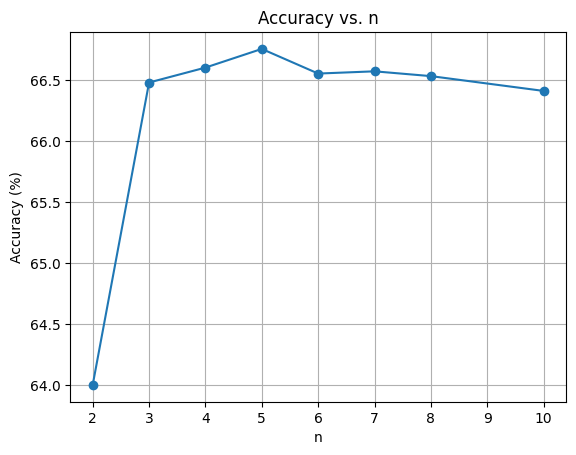

In [35]:
correct = 0
count = 0
n_results = []
n_values = [2, 3, 4, 5, 6, 7, 8, 10]
for n in n_values:
    CBR_agent = CaseBasedReasoning(n)
    CBR_agent.train()
    for idx in range(len(y_test)):
        count += 1
    #     CV_model_pred = model.predict(X_test_pad[idx:idx+1])

        play_info = lookup_by_index(plays[test_idx[idx]], training_labels.copy())
        if play_info.shape[0] == 0:
            continue
        pred, distance = CBR_agent.predict(play_info)
#         print("CBR agent pred", pred, distance)
#         print("Actual Type: " + types[np.argmax(y_test[idx])])
#         print("Play: " + str(plays[test_idx[idx]]))
        if types[np.argmax(y_test[idx])] == pred[0]:
            correct += 1
    acc = (correct/count) * 100
    n_results.append(acc)
    print("Test Accuracy: %.2f%%" % acc)
    
plt.plot(n_values, n_results, marker='o')
plt.xlabel('n')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. n')
plt.grid(True)

# Show the plot
plt.show()

### Rule Based Reasoning

In [21]:
def classify_play(df):
    play_types = []

    for index, row in df.iterrows():
        down = row['Down']
        to_go = row['ToGo']
        spot = row['Spot']
        text = row['Text']
        quarter = row['Quarter']

        if down == 4:
            if to_go > 5:
                play_types.append('Punt')
            else:
                play_types.append('Field Goal Attempt/Offensive Play')
        elif down == 1:
            if 'pass' in text.lower():
                play_types.append('Pass')
            elif 'run' in text.lower():
                play_types.append('Run')
            else:
                play_types.append('Run/Pass')
        elif down == 2:
            if to_go <= 3:
                play_types.append('Run')
            elif to_go >= 7:
                play_types.append('Pass')
            else:
                play_types.append('Run/Pass')
        elif down == 3:
            if to_go <= 3:
                play_types.append('Run')
            else:
                play_types.append('Pass')
        # Red Zone Logic
        elif '20' in spot:
            play_types.append('Touchdown Attempt')
        # Additional rules can be added here
        else:
            play_types.append('Other')

    df['PlayType'] = play_types
    return df

###  Rule Based Reasoning using Experta

In [22]:
from experta import KnowledgeEngine, Rule, Fact, Field
import pandas as pd

class Play(Fact):
    """
    Fact representing a football play.
    """
    pass

class FootballPlayClassifier(KnowledgeEngine):
    @Rule(Play(down=4, to_go=lambda to_go: to_go > 5))
    def rule_punt(self):
        print("Play classified as: Punt")

    @Rule(Play(down=4, to_go=lambda to_go: to_go <= 5))
    def rule_field_goal_or_offensive_play(self):
        print("Play classified as: Field Goal Attempt or Offensive Play")

    @Rule(Play(down=1))
    def rule_first_down(self):
        print("Play classified as: Run or Pass")

    @Rule(Play(down=2, to_go=lambda to_go: to_go <= 3))
    def rule_second_and_short(self):
        print("Play classified as: Likely Run")

    @Rule(Play(down=2, to_go=lambda to_go: to_go >= 7))
    def rule_second_and_long(self):
        print("Play classified as: Likely Pass")

    # Additional rules to be added

def create_frame(row):
    """
    Convert a DataFrame row to a frame (dictionary).
    """
    return {
        'id': row['ID'],
        'down': row['Down'],
        'to_go': row['ToGo'],
        'spot': row['Spot'],
        'text': row['Text'],
        'quarter': row['Quarter'],
        'has_ball': row['HasBall'],
        'type': row['Type'],
        'video_file_name': row['VideoFileName'],
        'video_path': row['VideoPath'],
        'play_id': row['PlayID'],
        'game_id': row['GameID']
    }

def classify_plays_with_experta(df):
    engine = FootballPlayClassifier()

    for _, row in df.iterrows():
        frame = create_frame(row)
        engine.reset()
        play_fact = Play(**frame)
        engine.declare(play_fact)
        engine.run()

ModuleNotFoundError: No module named 'experta'

In [ ]:
df = pd.DataFrame()
for idx in range(len(y_test)):
    count+=1
    play_info = lookup_by_index(plays[test_idx[idx]], training_labels.copy())
    df = df._append(play_info)
    if play_info.shape[0] == 0:
        continue

### Fusion Model

In [ ]:
# will be performing choose between case based reasoning, rule based reasoning, and computer vision model

# types = ['K', 'R', 'P', 'X', 'F', 'U']
types = ['K', 'R', 'P', 'X/F', 'U']
correct = 0
count = 0
CBR_agent = CaseBasedReasoning()
CBR_agent.train()
# result = lookup_by_index('264_1_000', training_labels)
# print(result)
# pred, distance = CBR_agent.predict(result)
# print(pred, distance)


for idx in range(len(y_test)):
    count += 1
#     CV_model_pred = model.predict(X_test_pad[idx:idx+1])

    print("here" ,plays[test_idx[idx]])
    play_info = lookup_by_index(plays[test_idx[idx]], training_labels.copy())
    print("play info" ,play_info)
    if play_info:
        continue
    pred, distance = CBR_agent.predict(play_info)
    print("CBR agent pred", pred, distance)
    print("Play Type: " + types[np.argmax(pred)])
    print("Actual Type: " + types[np.argmax(y_test[idx])])
    print("Play: " + str(plays[test_idx[idx]]))
    if np.argmax(y_test[idx]) == np.argmax(pred):
        correct += 1
acc = (correct/count) * 100
print("Test Accuracy: %.2f%%" % acc)

In [23]:
# Checking results for specific classes

#types = ['K', 'R', 'P', 'X', 'F', 'U']
types = ['K', 'R', 'P', 'X/F', 'U']
corrects =  [0.0 for _ in range(len(types))]
counts = [0.0 for _ in range(len(types))]


for idx in range(len(y_test)):
    counts[np.argmax(y_test[idx])] += 1.0
    pred = model.predict(X_test_pad[idx:idx+1])
    print("Play Type: " + types[np.argmax(pred)])
    print("Actual Type: " + types[np.argmax(y_test[idx])])
    print("Play: " + str(plays[test_idx[idx]]))
    if np.argmax(y_test[idx]) == np.argmax(pred):
            corrects[np.argmax(y_test[idx])] += 1.0


for i in range(len(types)):
    print(types[i] + " Accuracy: %.2f%%" % (100 * corrects[i]/counts[i]))

1/1 [==============================] - 1s 945ms/step
Play Type: R
Actual Type: P
Play: 264_1_014
1/1 [==============================] - 0s 27ms/step
Play Type: P
Actual Type: R
Play: 264_1_022
1/1 [==============================] - 0s 25ms/step
Play Type: X/F
Actual Type: R
Play: 264_1_031
1/1 [==============================] - 0s 27ms/step
Play Type: X/F
Actual Type: R
Play: 264_1_036
1/1 [==============================] - 0s 29ms/step
Play Type: R
Actual Type: R
Play: 264_2_012
1/1 [==============================] - 0s 27ms/step
Play Type: K
Actual Type: P
Play: 264_2_023
1/1 [==============================] - 0s 25ms/step
Play Type: P
Actual Type: R
Play: 264_2_031
1/1 [==============================] - 0s 28ms/step
Play Type: X/F
Actual Type: R
Play: 264_3_003
1/1 [==============================] - 0s 27ms/step
Play Type: R
Actual Type: R
Play: 264_3_011
1/1 [==============================] - 0s 29ms/step
Play Type: R
Actual Type: X/F
Play: 264_3_012
1/1 [==========================

In [ ]:
# Plotting Accuracy and Loss

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Checking results for specific classes

# types = ['K', 'R', 'P', 'X', 'F', 'U']
types = ['K', 'R', 'P', 'X/F', 'U']
correct = 0
count = 0

for idx in range(len(y_test)):
    if types[np.argmax(y_test[idx])] == 'U':
        count += 1
        pred = model.predict(X_test_pad[idx:idx+1])
        print("Play Type: " + types[np.argmax(pred)])
        print("Actual Type: " + types[np.argmax(y_test[idx])])
        print("Play: " + str(plays[test_idx[idx]]))
        print()
        if np.argmax(y_test[idx]) == np.argmax(pred):
            correct += 1
acc = (correct/count) * 100
print("Test Accuracy: %.2f%%" % acc)

In [ ]:
# Saving Model
model.save('cnn_rnn_model_final.h5')